<a href="https://colab.research.google.com/github/digital-science/dimensions-api-lab/blob/master/3-workshops/2019-04-Technical-University-of-Denmark/5-Citations-by-year-of-citation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Dimensions API Lab In Google Colab"/></a>

## Citations by year of citation

In [1]:
from dimcli.shortcuts import dslquery_json as dslquery
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import Image

## 1)  Seed your citation graph
Define a function that will give you back the publications that you want to start your citation graph from.

This example uses a single publication, but you could choose to look at a set of publications using any query.

In [2]:
def searchPubs(limit=1000, skip=0):
    data = """search publications 
          where id="pub.1001131784"
          return publications[id+times_cited+year]
          limit {} skip {}
    """.format(limit,skip)
    return data

## 2) Get the citing papers
Define a function that returns the citing papers, and the details that you will need to process them.

In [3]:
def citedpublications(ids,limit=1000,skip=0):
    data = """search publications
                  where (references in [{}])
              return publications[id+year+references] sort by id
                  limit {} skip {}
    """.format(','.join(['"{}"'.format(id) for id in ids]),limit,skip)
    print(skip)
    return data

## 3) Process the citing papers and get a 1 degree citation graph
For the set of papers that you are interested in, process the citing papers to extract the relevant 1d citation graph, partitoned by year

In [4]:
def dslsearchcitedpublications(cited_ids):
    
    idchunks = [cited_ids[x:x + 500] for x in range(0, len(cited_ids), 500)]
    result = {}
    years = {}
    
    total_pubs = []
    for idc in idchunks:        
        skip = 0
        pubs = []        
        while skip == 0 or len(pubs)== 1000:
            pubs = dslquery(citedpublications(idc, skip=skip)).get('publications',[])
            total_pubs += pubs
            skip += 1000   
    
    for i, p in enumerate(total_pubs):

        rs= []
        
        for r in p['references']:
            try:
                rs.append(r)
            except:
                print("found this anomalous data {}".format(r))
                
        references_set = set(rs)
        
        #Only return those citations that refer to the cited_ids  
        #(you could actually speed this set up by using dataframes)
        focusedcites = list(references_set - set(references_set - set(cited_ids)))

        #Citation graph
        citelinks = ["{}-{}".format(p['id'],f) for f in focusedcites]

        #Cumulatively partition Citation graph by year of citing publication
        year_key = str(p.get('year','no_year'))
        if year_key in years.keys():
            years[year_key] = list(set(years[year_key] + citelinks))
        else:
            years[year_key] = citelinks
 
    return years

## Put the steps together

* Get the publications you are interested in 
* Then get and process the publications that cite them

In [5]:
def dslsearchpublications():
    skip = 0
    pubs = []
    total_pubs = []
    result = {}
    while (skip == 0) or (len(pubs) == 1000):
        pubs = dslquery(searchPubs(skip=skip)).get('publications',[])
        total_pubs += pubs
        skip += 1000   
        
    result['ciations_by_citing_year'] = dslsearchcitedpublications([p['id'] for p in total_pubs])
                         
    return result

In [6]:
result = dslsearchpublications()

Execution time: 0.46980810165405273
0
Execution time: 1.2476401329040527


In [7]:
cbyc = []
for k in result['ciations_by_citing_year'].keys():
    cbyc.append([ k, len(result['ciations_by_citing_year'][k])])

In [8]:
df = pd.DataFrame(cbyc)

In [9]:
df.columns = ['year','citation_count']

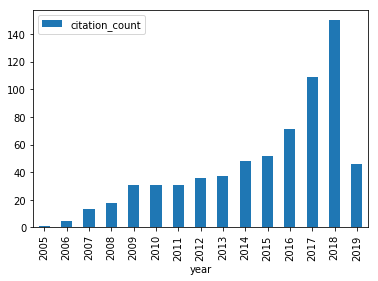

In [10]:
#Primary Citations by year of citation
df.set_index('year').sort_index().plot.bar()

---
# Want to learn more?

Check out the [Dimensions API Lab](https://digital-science.github.io/dimensions-api-lab/) website, which contains many tutorials and reusable Jupyter notebooks for scholarly data analytics. 